# **1. Develop a Character-Based Neural Language Model**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1. Data Preparation

In [2]:
# 1. load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close
  file.close()
  return text

# 2. save tokens to file, one dialog per line
def save_doc(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

# load text
raw_text = load_doc('/content/drive/MyDrive/Dataset/rhyme.txt') 
print(raw_text)
# clean
tokens = raw_text.split() 
raw_text = ' '.join(tokens)
# organize into sequences of characters
length = 10
sequences = list()
for i in range(length, len(raw_text)):
  # select sequence of tokens
  seq = raw_text[i-length:i+1]
  # store
  sequences.append(seq)

print('Total Sequences: %d' % len(sequences)) 
# save sequences to file
out_filename = 'char_sequences.txt' 
save_doc(sequences, out_filename)

Sing a song of sixpence,
A pocket full of rye.
Four and twenty blackbirds,
Baked in a pie.

When the pie was opened
The birds began to sing;
Wasn't that a dainty dish,
To set before the king.

The king was in his counting house,
Counting out his money;
The queen was in the parlour,
Eating bread and honey.

The maid was in the garden,
Hanging out the clothes,
When down came a blackbird
And pecked off her nose.
Total Sequences: 399


## 1.2. Train Language Model

In [ ]:
import numpy as np
from pickle import dump
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# 1.load doc into memory
def load_doc(filename):
  # open the file as read only 
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file 
  file.close()
  return text

# 2. define the model
def define_model(X):
  model = Sequential()
  model.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
  model.add(Dense(vocab_size, activation='softmax'))
  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # summarize defined model
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

# load
in_filename = 'char_sequences.txt'
raw_text = load_doc(in_filename)
lines = raw_text.split('\n')

# integer encode sequences of characters
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars)) 
sequences = list()

for line in lines:
  # integer encode line
  encoded_seq = [mapping[char] for char in line]
  # store
  sequences.append(encoded_seq)

# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)

# separate into input and output
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
sequences = [to_categorical(x, num_classes=vocab_size) for x in X] 
X = np.array(sequences)
y = to_categorical(y, num_classes=vocab_size)

# define model
model = define_model(X)
# fit model
model.fit(X, y, epochs=100, verbose=2)
# save the model to file
model.save('model.h5')
# save the mapping
dump(mapping, open('mapping.pkl', 'wb'))

Vocabulary Size: 38
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 75)                34200     
_________________________________________________________________
dense_3 (Dense)              (None, 38)                2888      
Total params: 37,088
Trainable params: 37,088
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 - 2s - loss: 3.6003 - accuracy: 0.1378
Epoch 2/100
13/13 - 0s - loss: 3.4460 - accuracy: 0.1905
Epoch 3/100
13/13 - 0s - loss: 3.1144 - accuracy: 0.1905
Epoch 4/100
13/13 - 0s - loss: 3.0363 - accuracy: 0.1930
Epoch 5/100
13/13 - 0s - loss: 2.9996 - accuracy: 0.1905
Epoch 6/100
13/13 - 0s - loss: 2.9816 - accuracy: 0.1905
Epoch 7/100
13/13 - 0s - loss: 2.9666 - accuracy: 0.1905
Epoch 8/100
13/13 - 0s - loss: 2.9443 - accuracy: 0.1905
Epoch 9/100
13/13 - 0s - loss: 2.924

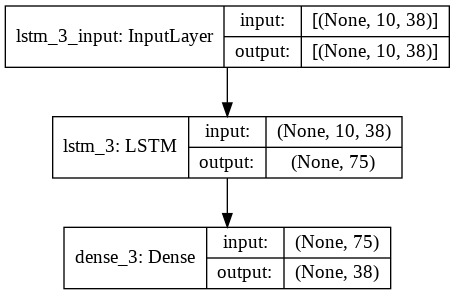

In [ ]:
plot_model(model, show_shapes= True)

## 1.3. Generate Text

In [ ]:
from pickle import load
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

# generate a sequence of characters with a language model
def generate_seq(model, mapping, seq_length, seed_text, n_chars):
  in_text = seed_text
  # generate a fixed number of characters
  for _ in range(n_chars):
    # encode the characters as integers
    encoded = [mapping[char] for char in in_text]
    # truncate sequences to a fixed length
    encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre') 
    # one hot encode
    encoded = to_categorical(encoded, num_classes=len(mapping))
    encoded = encoded.reshape(1, encoded.shape[0], encoded.shape[1])
    # predict character
    yhat = model.predict_classes(encoded, verbose=0)
    # reverse map integer to character
    out_char = ''
    for char, index in mapping.items():
      if index == yhat:
       out_char = char
       break
    # append to input
    in_text += out_char
  return in_text

# load the model
model = load_model('model.h5') 
# load the mapping
mapping = load(open('mapping.pkl', 'rb'))
# test start of rhyme
print(generate_seq(model, mapping, 10, 'Sing a son', 20)) 
# test mid-line
print(generate_seq(model, mapping, 10, 'king was i', 20)) 
# test not in original
print(generate_seq(model, mapping, 10, 'hello worl', 20))


ValueError: ignored

# **2. Develop a Word-Based Neural Language model**

## 2.1. Model 1: One-Word_in, One-Word-Out Sequences

In [10]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding


# generate a sequence from the model

def generate_seq(model, tokenizer, seed_text, n_words):
  in_text, result = seed_text, seed_text
  # generate a fixed number of words
  for _ in range(n_words):
    # encode the text as integer
    encoded = tokenizer.texts_to_sequences([in_text])[0]
    encoded = np.array(encoded)
    # predict a word in the vocabulary
    predict_x=model.predict(encoded, verbose=0) 
    yhat=np.argmax(predict_x,axis=1)
    # map predicted word index to word
    out_word = ''
    for word, index in tokenizer.word_index.items():
      if index == yhat:
        out_word = word
        break
    # append to input
    in_text, result = out_word, result + ' ' + out_word
  return result


# define the model
def define_model(vocab_size):
  model = Sequential()
  model.add(Embedding(vocab_size, 10, input_length = 1))
  model.add(LSTM(50))
  model.add(Dense(vocab_size, activation = 'softmax'))
  # compile network
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file ='model.png', show_shapes = True)
  return model


# source text
data = """ Jack and Jill went up the hill\n
    To fetch a pail of water\n
    Jack fell down and broke his crown\n
    And Jill came tumbling after\n """

# integer encode text
tokenizer = Tokenizer() 
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] 

# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1 
print('Vocabulary Size: %d' % vocab_size)

# create word -> word sequences
sequences = list()
for i in range(1, len(encoded)):
  sequence = encoded[i-1:i+1]
  sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
# split into X and y elements
sequences = np.array(sequences)
X, y = sequences[:,0],sequences[:,1]
# one hot encode outputs
y = to_categorical(y, num_classes=vocab_size)
# define model
model = define_model(vocab_size)
# fit network
model.fit(X, y, epochs=500, verbose=2)
# evaluate
print(generate_seq(model, tokenizer, 'Jack', 6))

Vocabulary Size: 22
Total Sequences: 24
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1, 10)             220       
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_4 (Dense)              (None, 22)                1122      
Total params: 13,542
Trainable params: 13,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 2s - loss: 3.0920 - accuracy: 0.0000e+00
Epoch 2/500
1/1 - 0s - loss: 3.0912 - accuracy: 0.0417
Epoch 3/500
1/1 - 0s - loss: 3.0904 - accuracy: 0.2083
Epoch 4/500
1/1 - 0s - loss: 3.0896 - accuracy: 0.2083
Epoch 5/500
1/1 - 0s - loss: 3.0888 - accuracy: 0.1250
Epoch 6/500
1/1 - 0s - loss: 3.0880 - accuracy: 0.1250
Epoch 

## 2.2. Model 2: Line-by-Line Sequence

In [15]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding


# generate a sequence from the model

def generate_seq(model, tokenizer, max_length, seed_text, n_words):
  in_text = seed_text
  # generate a fixed number of words
  for _ in range(n_words):
    # encode the text as integer
    encoded = tokenizer.texts_to_sequences([in_text])[0]
    # pre-pad sequences to a fixed length
    encoded = pad_sequences([encoded], maxlen = max_length, padding = 'pre')
    # predict a word in the vocabulary
    predict_x=model.predict(encoded, verbose=0) 
    yhat=np.argmax(predict_x,axis=1)
    # map predicted word index to word
    out_word = ''
    for word, index in tokenizer.word_index.items():
      if index == yhat:
        out_word = word
        break
    # append to input
    in_text +=  ' ' + out_word
  return in_text


# define the model
def define_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 10, input_length = max_length-1))
  model.add(LSTM(50))
  model.add(Dense(vocab_size, activation = 'softmax'))
  # compile network
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file ='model.png', show_shapes = True)
  return model


# source text
data = """ Jack and Jill went up the hill\n
    To fetch a pail of water\n
    Jack fell down and broke his crown\n
    And Jill came tumbling after\n """

# prepare the tokenizer on the source text 
tokenizer = Tokenizer() 
tokenizer.fit_on_texts([data])
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1 
print('Vocabulary Size: %d' % vocab_size)

# create line-based sequences
sequences = list()
for line in data.split('\n'):
  encoded = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(encoded)):
    sequence = encoded[:i+1]
    sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

# pad input sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre') 
print('Max Sequence Length: %d' % max_length)
# split into input and output elements
sequences = np.array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
# define model
model = define_model(vocab_size, max_length)
# fit network
model.fit(X, y, epochs=500, verbose=2)
# evaluate model
print(generate_seq(model, tokenizer, max_length-1, 'Jack', 4)) 
print(generate_seq(model, tokenizer, max_length-1, 'Jill', 4))

Vocabulary Size: 22
Total Sequences: 21
Max Sequence Length: 7
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 6, 10)             220       
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_7 (Dense)              (None, 22)                1122      
Total params: 13,542
Trainable params: 13,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 2s - loss: 3.0920 - accuracy: 0.0000e+00
Epoch 2/500
1/1 - 0s - loss: 3.0904 - accuracy: 0.0000e+00
Epoch 3/500
1/1 - 0s - loss: 3.0889 - accuracy: 0.0000e+00
Epoch 4/500
1/1 - 0s - loss: 3.0873 - accuracy: 0.0476
Epoch 5/500
1/1 - 0s - loss: 3.0856 - accuracy: 0.0476
Epoch 6/500
1/1 - 0s - loss: 3

## 2.3. Model 3: Two-Words-In, One-Word-Out Sequence


In [22]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
  in_text = seed_text
  # generate a fixed number of words
  for _ in range(n_words):
    # encode the text as integer
    encoded = tokenizer.texts_to_sequences([in_text])[0]
    # pre-pad sequences to a fixed length
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre') 
    # predict probabilities for each word
    predict_x=model.predict(encoded, verbose=0) 
    yhat=np.argmax(predict_x,axis=1)
    # map predicted word index to word
    out_word = ''
    for word, index in tokenizer.word_index.items():
     if index == yhat:
       out_word = word
       break
    # append to input
    in_text += ' ' + out_word 
  return in_text




# define the model
def define_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 10, input_length=max_length-1))
  model.add(LSTM(50))
  model.add(Dense(vocab_size, activation='softmax'))
  # compile network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # summarize defined model
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

# source text
data = """ Jack and Jill went up the hill\n
    To fetch a pail of water\n
    Jack fell down and broke his crown\n
    And Jill came tumbling after\n """
# integer encode sequences of words
tokenizer = Tokenizer() 
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] 
# retrieve vocabulary size
vocab_size = len(tokenizer.word_index) + 1 
print('Vocabulary Size: %d' % vocab_size)
# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
  sequence = encoded[i-2:i+1]
  sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
# pad sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)
# split into input and output elements
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
# define model
model = define_model(vocab_size, max_length)
# fit network
model.fit(X, y, epochs=500, verbose=2)
# evaluate model
print(generate_seq(model, tokenizer, max_length-1, 'Jack and', 5)) 
print(generate_seq(model, tokenizer, max_length-1, 'And Jill', 3)) 
print(generate_seq(model, tokenizer, max_length-1, 'fell down', 5)) 
print(generate_seq(model, tokenizer, max_length-1, 'pail of', 5))

Vocabulary Size: 22
Total Sequences: 23
Max Sequence Length: 3
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 2, 10)             220       
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                12200     
_________________________________________________________________
dense_12 (Dense)             (None, 22)                1122      
Total params: 13,542
Trainable params: 13,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 2s - loss: 3.0914 - accuracy: 0.0870
Epoch 2/500
1/1 - 0s - loss: 3.0905 - accuracy: 0.1739
Epoch 3/500
1/1 - 0s - loss: 3.0897 - accuracy: 0.1304
Epoch 4/500
1/1 - 0s - loss: 3.0888 - accuracy: 0.0870
Epoch 5/500
1/1 - 0s - loss: 3.0879 - accuracy: 0.0870
Epoch 6/500
1/1 - 0s - loss: 3.0871 - acc

# 3. Develop a Neural Language Model for Text Generation

In [ ]:
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
# load doc into memory
def load_doc(filename):
# open the file as read only file = open(filename, 'r')
# read all text
text = file.read()
# close the file file.close()
return text


# define the model
def define_model(vocab_size, seq_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=seq_length))
  model.add(LSTM(100, return_sequences=True))
  model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # summarize defined model
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)
return model
# load
in_filename = 'republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
# integer encode sequences of words
tokenizer = Tokenizer() tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines) # vocabulary size
vocab_size = len(tokenizer.word_index) + 1
# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]
# define model
model = define_model(vocab_size, seq_length)
# fit model
model.fit(X, y, batch_size=128, epochs=100)
# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))